## Leer datos

In [ ]:
from pathlib import Path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import runpy, importlib.util, importlib.machinery

In [7]:
#Localizar la carpeta raiz
def find_root(start: Path = Path.cwd(), marker: str = "data_sintetica", max_up: int = 8) -> Path:
    p = start.resolve()
    for _ in range(max_up):
        if (p / marker).exists():
            return p
        p = p.parent
    raise FileNotFoundError(f"No se encontró la carpeta '{marker}' al subir directorios.")

ROOT = find_root()
PKL_PATH = ROOT / "data_sintetica" / "hipermercados.pkl"
OUT_DIR  = ROOT / "resultado de modelos"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT ->", ROOT)
print("PKL_PATH ->", PKL_PATH)

ROOT -> D:\IC\Y03AN1_Machine_Learning_I
PKL_PATH -> D:\IC\Y03AN1_Machine_Learning_I\data_sintetica\hipermercados.pkl


In [8]:
#Si no existe el PKL, intenta generarlo
if not PKL_PATH.exists():
    gens = list(ROOT.glob("**/data_sintetica_hipermercados.py"))
    if not gens:
        raise FileNotFoundError("No existe el PKL y no se encontró el archivo python")
    gen_file = str(gens[0])
    print("Generador localizado en: ", gen_file)

    #1) primer intento, ejecutar como __main__
    try:
        runpy.run_path(gen_file, run_name="__main__")
    except Exception as e:
        print("runpy.run_path falló, inteto alternativo: ",e)

df = pd.read_pickle(PKL_PATH)
df.head()

Generador localizado en:  D:\IC\Y03AN1_Machine_Learning_I\semana6\data_sintetica_hipermercados.py
✅ PKL guardado en: D:\IC\Y03AN1_Machine_Learning_I\data_sintetica\hipermercados.pkl | Filas: 50,000


,id_tx,tienda,segmento_ingreso,puntos_lealtad,frecuencia_hist,clima,fin_semana,hora,trafico_tienda,promo_tipo,cabecera_gondola,cross_selling,degustacion,n_items,ticket_soles,compra_impulsiva,ticket_alto
0,1,Hiper Vecinal,Medio,24,6,Soleado,1,15,254,2x1,1,1,0,10,89.27,1,0
1,2,Hiper Vecinal,Medio,46,6,Nublado,0,11,203,Descuento,0,1,0,6,88.37,1,0
2,3,Hiper Urbano,Bajo,40,9,Soleado,0,22,223,2x1,1,1,0,10,67.88,1,1
3,4,Hiper Vecinal,Bajo,17,1,Lluvioso,0,22,187,2x1,0,1,0,6,60.39,1,0
4,5,Hiper Vecinal,Medio,115,4,Nublado,1,19,247,2x1,1,1,0,10,70.24,0,0


In [9]:
#Preparación y modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [11]:
y = df["compra_impulsiva"]
X = df.drop(columns=["compra_impulsiva", "ticket_alto"])

cat_cols = ["tienda", "segmento_ingreso", "clima","promo_tipo"]
num_cols = [c for c in X.columns if c not in cat_cols and c != "id_tx"]

pre = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("sc", StandardScaler(), num_cols),
])

models = {
    "logistic": LogisticRegression(max_iter=200, n_jobs=None),
    "rf" : RandomForestClassifier(n_estimators=200, random_state=42),
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

results, fitted = {}, {}
for name, clf in models.items():
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    results[name] = dict(
        accuracy = accuracy_score(y_test, y_pred),
        precision= precision_score(y_test, y_pred),
        recall   = recall_score(y_test, y_pred),
        f1       = f1_score(y_test, y_pred),
        roc_auc  = roc_auc_score(y_test, y_proba),
    )
    fitted[name] = pipe

pd.DataFrame(results).T.round(4)

,accuracy,precision,recall,f1,roc_auc
logistic,0.9952,0.9968,0.9875,0.9921,0.9999
rf,0.9999,0.9997,1.0000,0.9999,1.0000


<function matplotlib.pyplot.show(close=None, block=None)>

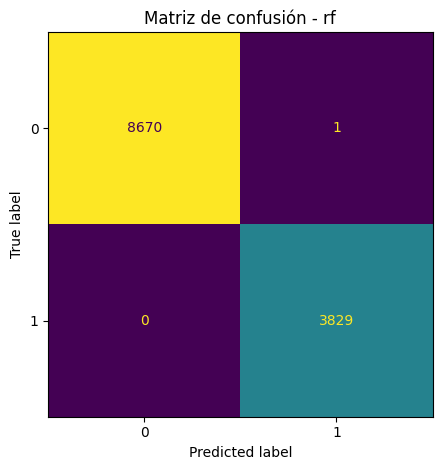

In [14]:
res_df = pd.DataFrame(results).T
best_name = res_df["f1"].idxmax()
best = fitted[best_name]

#matriz
y_pred = best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm).plot(ax = ax, colorbar=False)
plt. title(f"Matriz de confusión - {best_name}")
fig.tight_layout()
fig.savefig(OUT_DIR/"clasificacion_matriz_confusion.png", dpi=150)
plt.show

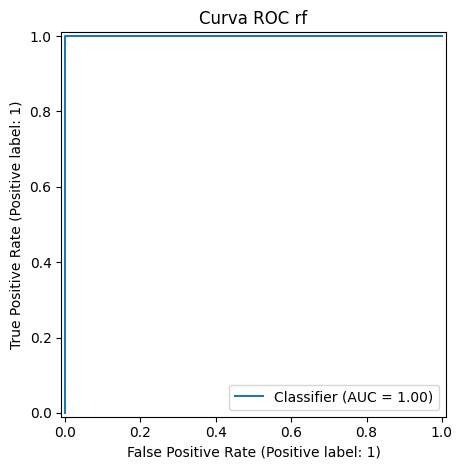

In [16]:
y_proba = best.predict_proba(X_test)[:,1]
fig2, ax2 = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax2)
plt.title(f"Curva ROC {best_name}")
fig2.tight_layout()
fig2.savefig(OUT_DIR/"clasificacion_curva_roc.png", dpi=150)
plt.show()